In [1]:
import pandas as pd
import numpy as np
import torch

Given the absence of specific data for the model, I proceeded to predict photovoltaic power generation by leveraging preprocessing and feature engineering techniques using data retrieved from https://dkasolarcentre.com.au/download?location=alice-springs. 
This demonstration encompasses four distinct models: LSTM, LSTM+CNN, LSTM+CNN+Attention, and RNN.

In [2]:
dataset = pd.read_csv('./96-Site_DKA-MasterMeter1.csv')
print(dataset)

                   timestamp  Active_Energy_Delivered_Received  \
0        2008-09-12 05:55:00                         -2.638068   
1        2008-09-12 06:00:00                         -2.658491   
2        2008-09-12 06:05:00                         -2.678929   
3        2008-09-12 06:10:00                         -2.699341   
4        2008-09-12 06:15:00                         -2.719728   
...                      ...                               ...   
1617979  2024-03-18 21:10:00                      51976.898438   
1617980  2024-03-18 21:15:00                      51976.875000   
1617981  2024-03-18 21:20:00                      51976.851562   
1617982  2024-03-18 21:25:00                               NaN   
1617983  2024-03-18 21:30:00                               NaN   

         Current_Phase_Average  Active_Power  Power_Factor_Signed  \
0                          NaN     -0.245161                  NaN   
1                          NaN     -0.245080                  NaN   


In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617984 entries, 0 to 1617983
Data columns (total 17 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   timestamp                         1617984 non-null  object 
 1   Active_Energy_Delivered_Received  1607966 non-null  float64
 2   Current_Phase_Average             906715 non-null   float64
 3   Active_Power                      1607996 non-null  float64
 4   Power_Factor_Signed               906418 non-null   float64
 5   Average_Voltage_Line_to_Neutral   1608304 non-null  float64
 6   Frequency                         1607554 non-null  float64
 7   THD_Voltage_Average               906715 non-null   float64
 8   Wind_Speed                        841771 non-null   float64
 9   Weather_Temperature_Celsius       1602018 non-null  float64
 10  Weather_Relative_Humidity         1602024 non-null  float64
 11  Global_Horizontal_Radiation       160

Data preprocessing + feature engineering

In [4]:
dataset.sort_index(inplace=True)
pre_mins = 6
dataset['label'] = dataset['Active_Power'].shift(-pre_mins)
dataset.loc[:,['timestamp','Active_Power','label']]

,timestamp,Active_Power,label
0,2008-09-12 05:55:00,-0.245161,-0.244965
1,2008-09-12 06:00:00,-0.245080,-0.245112
2,2008-09-12 06:05:00,-0.245251,-0.244981
3,2008-09-12 06:10:00,-0.244939,-0.244806
4,2008-09-12 06:15:00,-0.244650,-0.244803
...,...,...,...
1617979,2024-03-18 21:10:00,-0.278133,NaN
1617980,2024-03-18 21:15:00,-0.277642,NaN
1617981,2024-03-18 21:20:00,-0.278172,NaN
1617982,2024-03-18 21:25:00,NaN,NaN


In [5]:
dataset.fillna(0)

,timestamp,Active_Energy_Delivered_Received,Current_Phase_Average,Active_Power,Power_Factor_Signed,Average_Voltage_Line_to_Neutral,Frequency,THD_Voltage_Average,Wind_Speed,Weather_Temperature_Celsius,Weather_Relative_Humidity,Global_Horizontal_Radiation,Diffuse_Horizontal_Radiation,Wind_Direction,Weather_Daily_Rainfall,Radiation_Global_Tilted,Radiation_Diffuse_Tilted,label
0,2008-09-12 05:55:00,-2.638068,0.000000,-0.245161,0.000000,250.953476,50.006252,0.000000,0.0,25.734350,18.551216,5.227983,2.215820,103.423134,0.0,0.000000,0.000000,-0.244965
1,2008-09-12 06:00:00,-2.658491,0.000000,-0.245080,0.000000,250.978424,50.005299,0.000000,0.0,25.402353,19.242727,5.408280,2.435364,125.776703,0.0,0.000000,0.000000,-0.245112
2,2008-09-12 06:05:00,-2.678929,0.000000,-0.245251,0.000000,250.966934,50.005074,0.000000,0.0,25.141418,19.368038,4.931451,1.885518,163.055115,0.0,0.000000,0.000000,-0.244981
3,2008-09-12 06:10:00,-2.699341,0.000000,-0.244939,0.000000,250.784180,50.004089,0.000000,0.0,25.015263,19.301992,4.298166,1.327833,137.553268,0.0,0.000000,0.000000,-0.244806
4,2008-09-12 06:15:00,-2.719728,0.000000,-0.244650,0.000000,250.727081,50.003780,0.000000,0.0,24.935015,19.123230,4.499399,1.520790,128.099182,0.0,0.000000,0.000000,-0.244803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617979,2024-03-18 21:10:00,51976.898438,3.070728,-0.278133,10.612415,237.918442,50.002182,1.672243,0.0,29.055014,24.878325,2.159762,1.987410,31.182827,0.0,3.985574,1.196515,0.000000
1617980,2024-03-18 21:15:00,51976.875000,3.073568,-0.277642,10.628766,237.442062,50.003944,1.701861,0.0,29.108145,24.604557,1.439755,1.293333,31.194542,0.0,3.789649,1.039196,0.000000
1617981,2024-03-18 21:20:00,51976.851562,3.073921,-0.278172,10.620157,237.760483,50.001755,1.711048,0.0,29.166576,24.430258,1.438351,1.342394,31.179396,0.0,3.626018,0.986689,0.000000
1617982,2024-03-18 21:25:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.554056,0.911339,0.000000


In [6]:
# Select columns for correlation analysis
X = dataset.loc[0:1000, 'Wind_Speed']
Y = dataset.loc[0:1000, 'Active_Power']

# Perform correlation analysis
result_1 = X.corr(Y)
print("Correlation coefficient:", result_1)

# Exclude timestamp column and perform correlation analysis
numerical_dataset = dataset.drop(columns=['timestamp'])
result_3 = numerical_dataset.corr()
print(result_3)


Correlation coefficient: nan
                                  Active_Energy_Delivered_Received  \
Active_Energy_Delivered_Received                          1.000000   
Current_Phase_Average                                    -0.005981   
Active_Power                                              0.043629   
Power_Factor_Signed                                       0.019746   
Average_Voltage_Line_to_Neutral                          -0.088802   
Frequency                                                -0.004453   
THD_Voltage_Average                                       0.057786   
Wind_Speed                                               -0.045367   
Weather_Temperature_Celsius                              -0.018620   
Weather_Relative_Humidity                                 0.028783   
Global_Horizontal_Radiation                              -0.012307   
Diffuse_Horizontal_Radiation                              0.006105   
Wind_Direction                                            0.0

In [7]:
# Remove correlations less than 0.1
result_4 = result_3['Active_Power'][result_3['Active_Power'] > 0.1]
result_4 = result_4.drop('Active_Power')
result_4 = result_4.drop('Current_Phase_Average')
result_4 = result_4.drop('label')
print(type(result_4)) 
result_4

<class 'pandas.core.series.Series'>


Power_Factor_Signed                0.328131
Average_Voltage_Line_to_Neutral    0.166264
Wind_Speed                         0.184767
Weather_Temperature_Celsius        0.409983
Global_Horizontal_Radiation        0.948013
Diffuse_Horizontal_Radiation       0.521250
Radiation_Global_Tilted            0.984715
Radiation_Diffuse_Tilted           0.262088
Name: Active_Power, dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


<AxesSubplot:>

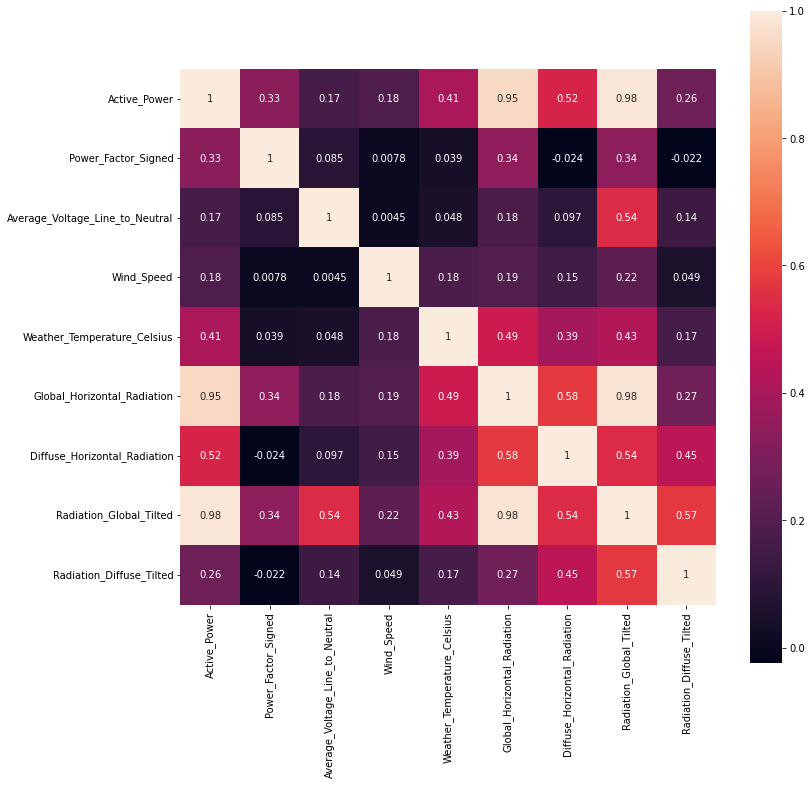

In [8]:
# Correlation plot
# Heatma
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
result_5 = dataset.loc[:,['Active_Power','Power_Factor_Signed','Average_Voltage_Line_to_Neutral','Wind_Speed','Weather_Temperature_Celsius','Global_Horizontal_Radiation','Diffuse_Horizontal_Radiation','Radiation_Global_Tilted',
'Radiation_Diffuse_Tilted']]
figure, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(result_5.corr(), square=True, annot=True, ax=ax)

In [9]:

col = ['timestamp','Power_Factor_Signed', 'Average_Voltage_Line_to_Neutral', 'Wind_Speed', 'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation', 'Diffuse_Horizontal_Radiation', 'Radiation_Global_Tilted', 'Radiation_Diffuse_Tilted','label']


filred_data = dataset[col]
filred_data.fillna(0, inplace=True)

filred_data = filred_data.reset_index(drop=True)
print(filred_data)

/tmp/ipykernel_2081/699375773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filred_data.fillna(0, inplace=True)


                   timestamp  Power_Factor_Signed  \
0        2008-09-12 05:55:00             0.000000   
1        2008-09-12 06:00:00             0.000000   
2        2008-09-12 06:05:00             0.000000   
3        2008-09-12 06:10:00             0.000000   
4        2008-09-12 06:15:00             0.000000   
...                      ...                  ...   
1617979  2024-03-18 21:10:00            10.612415   
1617980  2024-03-18 21:15:00            10.628766   
1617981  2024-03-18 21:20:00            10.620157   
1617982  2024-03-18 21:25:00             0.000000   
1617983  2024-03-18 21:30:00             0.000000   

         Average_Voltage_Line_to_Neutral  Wind_Speed  \
0                             250.953476         0.0   
1                             250.978424         0.0   
2                             250.966934         0.0   
3                             250.784180         0.0   
4                             250.727081         0.0   
...                        

In [10]:
# Using the 3-sigma method to identify values outside the range (u-3a, u+3a)
def three_sigma(ser):
    # Calculate the mean
    mean_data = ser.mean()
    # Calculate the standard deviation
    std_data = ser.std();
    # Define the rule for identifying outliers
    rule = (mean_data - 3 * std_data > ser) | (mean_data + 3 * std_data < ser)
    # Generate a continuous index from 0 to the length of the series minus 1
    # Then, select indices where the rule evaluates to True, indicating outliers
    index = np.arange(ser.shape[0])[rule]
    # Retrieve the outliers
    outliers = ser.iloc[index]
    return outliers

# Outlier handling
mean_data = filtered_data['Weather_Temperature_Celsius'].mean();
mean_data

21.078048889559355

821320    -39.987587
821321    -39.987572
821323    -39.987606
821324    -39.987576
821325    -39.987625
             ...    
1205676   -36.734642
1205677   -36.939594
1205678   -36.637794
1205684   -39.854279
1205685   -39.987770
Name: Weather_Temperature_Celsius, Length: 3051, dtype: float64


/tmp/ipykernel_2081/3517887488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data[i] = mean_data
/tmp/ipykernel_2081/3517887488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data[i] = mean_data
/tmp/ipykernel_2081/3517887488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data[i] = mean_data
/tmp/ipykernel_2081/3517887488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

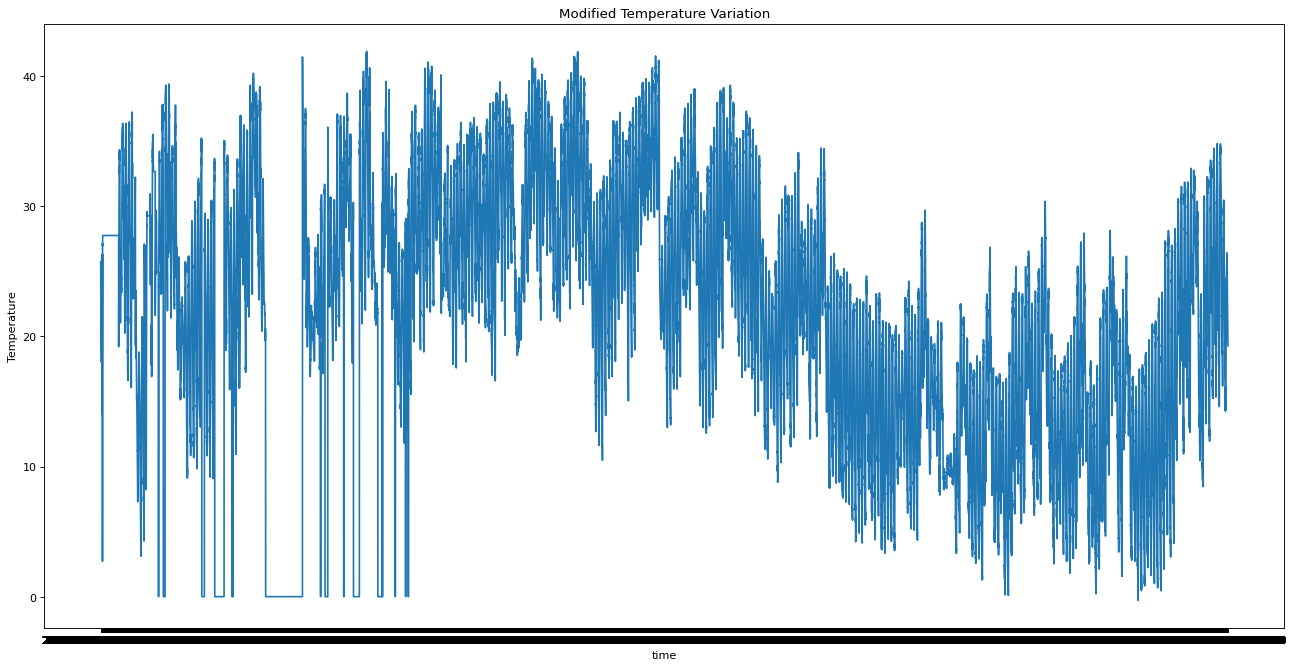

In [11]:
# Based on the graph, outlier processing is performed on Temperature 1 data: replaced with the mean value.
# Interpolation is also commonly used for this purpose.
error_data = three_sigma(filtered_data['Weather_Temperature_Celsius'])
true_data = filtered_data['Weather_Temperature_Celsius']
print(error_data)
for i, v in error_data.items():
    true_data[i] = mean_data

plt.figure(figsize=(20,10),dpi=80)
X_1 = filtered_data.loc[0:100000,'timestamp']
Y_1 = true_data[0:100001]
plt.plot(X_1,Y_1)
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Modified Temperature Variation')
plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler

# Create StandardScaler object
scaler = StandardScaler()

# Standardize the data
X_9 = scaler.fit_transform(filred_data.iloc[:, 1:10])
train_size = int(len(X_9) * 0.8)
test_size = len(X_9) - train_size
train_data = X_9[:train_size, :]  # Exclude the last column as train data
test_data = X_9[train_size:, :]  # Exclude the last column as test data

In [14]:
# LSTM model construction, multiple inputs single output
# Take data within a certain period of time as input, predict the label after that period of time, and continuously reduce the difference loss in the end
# Number of days to remember
men_days = 7

from collections import deque;
deq = deque(maxlen= men_days)

X_4 = []
for i in train_data:
    deq.append(list(i))
    if len(deq) == men_days:
        X_4.append(list((deq)))
X_Test = []
for i in test_data:
    deq.append(list(i))
    if len(deq) == men_days:
        X_Test.append(list((deq)))
        
X_4 = np.array(X_4)
X_Test = np.array(X_Test)

In [15]:
# Extracting data columns for training
x_train_data = train_data[:, :8]  # Exclude the last column as train data
y_train_data = train_data[:, -1]  # Get the last column as train labels

# Extracting data columns for testing
x_test_data = test_data[:, :8]  # Exclude the last column as test data
y_test_data = test_data[:, -1]  # Get the last column as test labels

In [16]:
y_train_data = np.array(y_train_data)
y_test_data = np.array(y_test_data)

LSTM model

Epoch [1/20], Train Loss: 0.0574, Test Loss: 0.1421
Epoch [2/20], Train Loss: 0.0953, Test Loss: 0.1399
Epoch [3/20], Train Loss: 0.0928, Test Loss: 0.1432
Epoch [4/20], Train Loss: 0.1036, Test Loss: 0.1430
Epoch [5/20], Train Loss: 0.0972, Test Loss: 0.1471
Epoch [6/20], Train Loss: 0.1402, Test Loss: 0.1413
Epoch [7/20], Train Loss: 0.0715, Test Loss: 0.1399
Epoch [8/20], Train Loss: 0.0685, Test Loss: 0.1384
Epoch [9/20], Train Loss: 0.1359, Test Loss: 0.1411
Epoch [10/20], Train Loss: 0.1098, Test Loss: 0.1365
Epoch [11/20], Train Loss: 0.0882, Test Loss: 0.1387
Epoch [12/20], Train Loss: 0.0574, Test Loss: 0.1376
Epoch [13/20], Train Loss: 0.0613, Test Loss: 0.1359
Epoch [14/20], Train Loss: 0.0495, Test Loss: 0.1376
Epoch [15/20], Train Loss: 0.1227, Test Loss: 0.1344
Epoch [16/20], Train Loss: 0.0892, Test Loss: 0.1330
Epoch [17/20], Train Loss: 0.1478, Test Loss: 0.1398
Epoch [18/20], Train Loss: 0.0478, Test Loss: 0.1358
Epoch [19/20], Train Loss: 0.1019, Test Loss: 0.1377
Ep

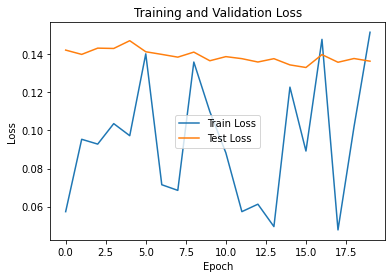

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_data, y_train_data, test_data, and y_test_data are properly defined
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(x_train_data, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(x_test_data, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Correctly handle tensor dimensions
        lstm_out, _ = self.lstm(x)
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Predict using fully connected layer
        output = self.fc(lstm_out)
        return output

# Get the number of features as input_size
input_size = 8
hidden_size = 32
output_size = 1

# Create model instance and move to GPU
model = LSTMModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred.squeeze(), y_test_tensor)
    test_losses.append(test_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


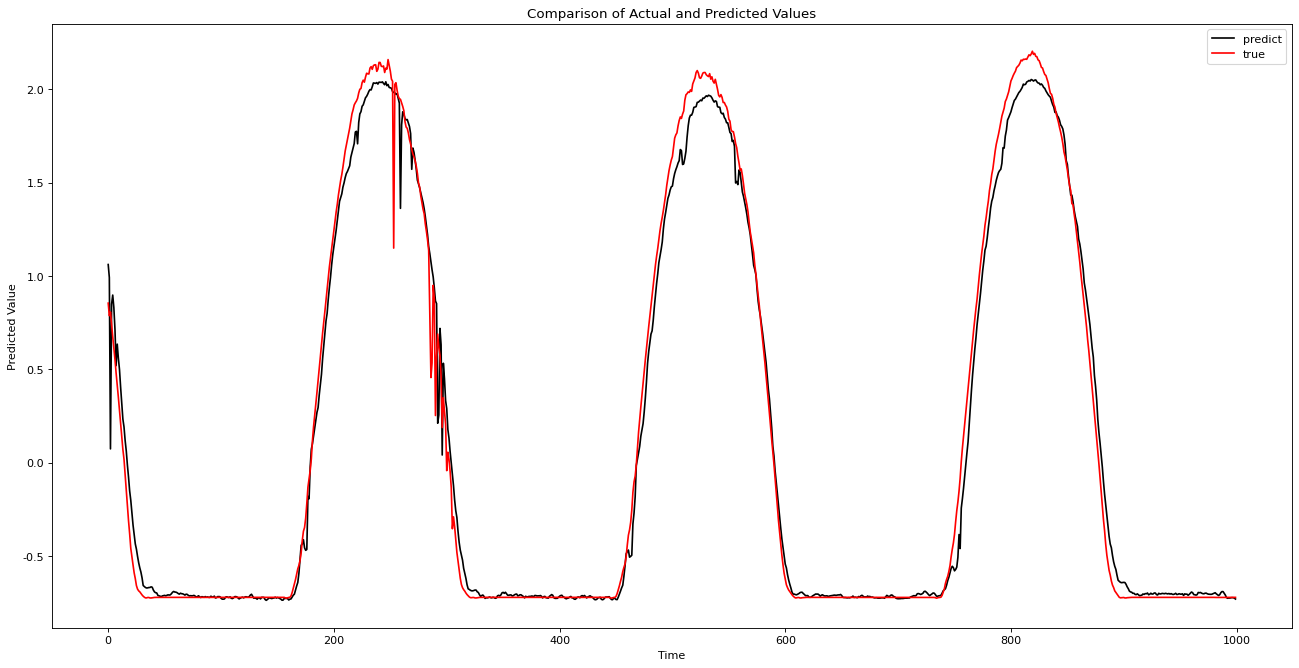

In [19]:

y_predict = y_pred.cpu().numpy()


num_test_samples = len(y_test_data)

x_predict = range(num_test_samples)

plt.figure(figsize=(20,10), dpi=80)
plt.plot(x_predict[:1000], y_predict[:1000], color='black', label='predict')
plt.plot(x_predict[:1000], y_test_data[:1000], color='red', label='true')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()


CNN+LSTM model

Epoch [1/20], Train Loss: 0.0648, Test Loss: 0.1327
Epoch [2/20], Train Loss: 0.0318, Test Loss: 0.1193
Epoch [3/20], Train Loss: 0.0769, Test Loss: 0.1356
Epoch [4/20], Train Loss: 0.0860, Test Loss: 0.1276
Epoch [5/20], Train Loss: 0.0224, Test Loss: 0.1344
Epoch [6/20], Train Loss: 0.0607, Test Loss: 0.1399
Epoch [7/20], Train Loss: 0.0802, Test Loss: 0.1558
Epoch [8/20], Train Loss: 0.0318, Test Loss: 0.1501
Epoch [9/20], Train Loss: 0.0538, Test Loss: 0.1576
Epoch [10/20], Train Loss: 0.0315, Test Loss: 0.1406
Epoch [11/20], Train Loss: 0.1345, Test Loss: 0.1460
Epoch [12/20], Train Loss: 0.0845, Test Loss: 0.1439
Epoch [13/20], Train Loss: 0.1687, Test Loss: 0.1400
Epoch [14/20], Train Loss: 0.0549, Test Loss: 0.1442
Epoch [15/20], Train Loss: 0.0708, Test Loss: 0.1411
Epoch [16/20], Train Loss: 0.0779, Test Loss: 0.1399
Epoch [17/20], Train Loss: 0.1510, Test Loss: 0.1434
Epoch [18/20], Train Loss: 0.0690, Test Loss: 0.1446
Epoch [19/20], Train Loss: 0.1219, Test Loss: 0.1448
Ep

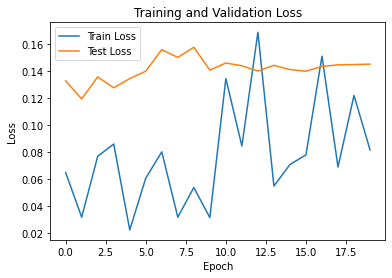

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Assuming train_data, y_train_data, test_data, and y_test_data are properly defined

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(x_train_data, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(x_test_data, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).to(device)

# Reshape the data for CNN
X_train_tensor = X_train_tensor.view(-1, 1, 8, 1)  # assuming 8 features
X_test_tensor = X_test_tensor.view(-1, 1, 8, 1)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(16, 32, kernel_size=(2, 1)),  # Modify kernel_size here
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        # Calculate the output size of CNN
        cnn_output_size = self._get_cnn_output_size(input_size)

        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def _get_cnn_output_size(self, input_size):
        # Create a dummy input and pass through CNN to get output size
        dummy_input = torch.zeros(1, 1, input_size, 1)
        cnn_output = self.cnn(dummy_input)
        return cnn_output.view(cnn_output.size(0), cnn_output.size(1), -1).size(2)

    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(cnn_out.size(0), cnn_out.size(1), -1)  # reshape for LSTM
        lstm_out, _ = self.lstm(cnn_out)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Get the number of features as input_size
input_size = 8
hidden_size = 32
output_size = 1

# Create model instance and move to GPU
model = CNNLSTM(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred.squeeze(), y_test_tensor)
    test_losses.append(test_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


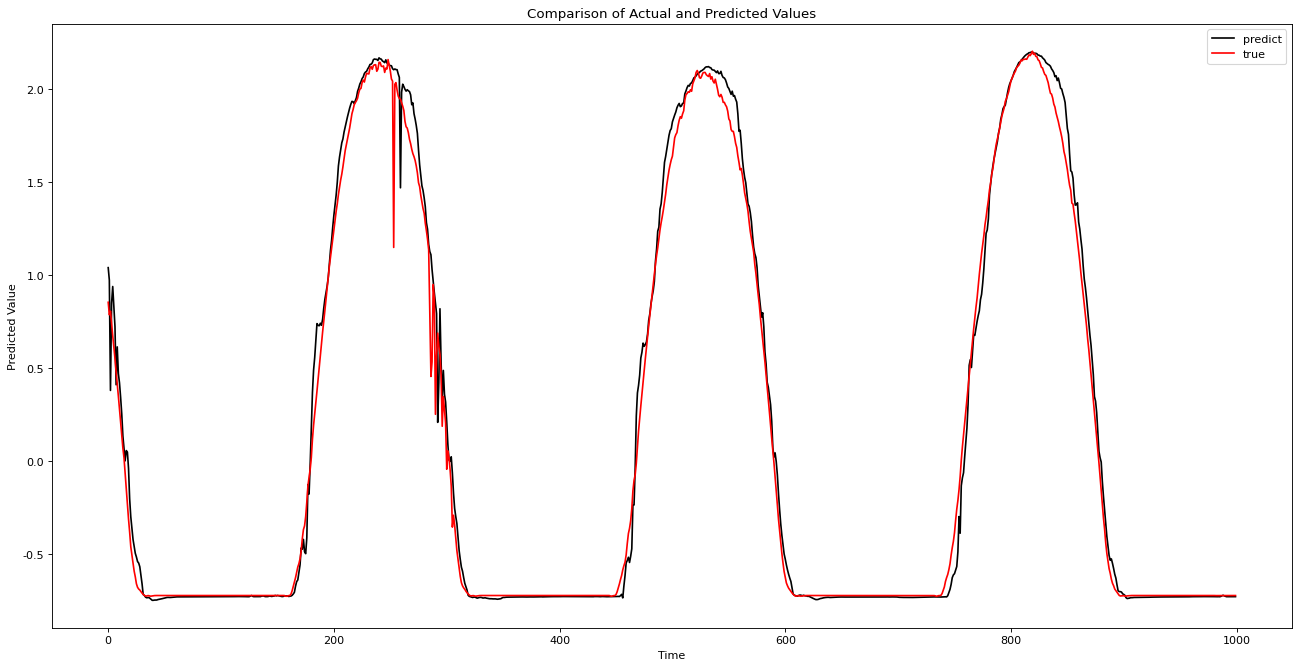

In [24]:

y_predict = y_pred.cpu().numpy()


num_test_samples = len(y_test_data)

x_predict = range(num_test_samples)

plt.figure(figsize=(20,10), dpi=80)
plt.plot(x_predict[:1000], y_predict[:1000], color='black', label='predict')
plt.plot(x_predict[:1000], y_test_data[:1000], color='red', label='true')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()


CNN+LSTM+Attention model

Epoch [1/20], Train Loss: 0.1554, Test Loss: 0.1301
Epoch [2/20], Train Loss: 0.1063, Test Loss: 0.1425
Epoch [3/20], Train Loss: 0.0743, Test Loss: 0.1334
Epoch [4/20], Train Loss: 0.0808, Test Loss: 0.1515
Epoch [5/20], Train Loss: 0.0336, Test Loss: 0.1526
Epoch [6/20], Train Loss: 0.1085, Test Loss: 0.1475
Epoch [7/20], Train Loss: 0.0806, Test Loss: 0.1441
Epoch [8/20], Train Loss: 0.1355, Test Loss: 0.1427
Epoch [9/20], Train Loss: 0.0441, Test Loss: 0.1512
Epoch [10/20], Train Loss: 0.1579, Test Loss: 0.1495
Epoch [11/20], Train Loss: 0.0878, Test Loss: 0.1423
Epoch [12/20], Train Loss: 0.1547, Test Loss: 0.1508
Epoch [13/20], Train Loss: 0.0467, Test Loss: 0.1436
Epoch [14/20], Train Loss: 0.0619, Test Loss: 0.1383
Epoch [15/20], Train Loss: 0.0775, Test Loss: 0.1393
Epoch [16/20], Train Loss: 0.0681, Test Loss: 0.1473
Epoch [17/20], Train Loss: 0.0326, Test Loss: 0.1508
Epoch [18/20], Train Loss: 0.0608, Test Loss: 0.1393
Epoch [19/20], Train Loss: 0.0498, Test Loss: 0.1369
Ep

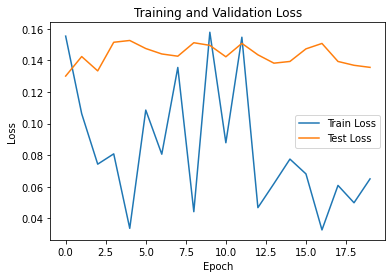

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Assuming train_data, y_train_data, test_data, and y_test_data are properly defined

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(x_train_data, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(x_test_data, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).to(device)

# Reshape the data for CNN
X_train_tensor = X_train_tensor.view(-1, 1, 8, 1)  # assuming 8 features
X_test_tensor = X_test_tensor.view(-1, 1, 8, 1)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class CNNLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads):
        super(CNNLSTMWithAttention, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(16, 32, kernel_size=(2, 1)),  # Modify kernel_size here
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        # Calculate the output size of CNN
        cnn_output_size = self._get_cnn_output_size(input_size)

        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads)
        self.fc = nn.Linear(hidden_size, output_size)

    def _get_cnn_output_size(self, input_size):
        # Create a dummy input and pass through CNN to get output size
        dummy_input = torch.zeros(1, 1, input_size, 1)
        cnn_output = self.cnn(dummy_input)
        return cnn_output.view(cnn_output.size(0), cnn_output.size(1), -1).size(2)

    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(cnn_out.size(0), cnn_out.size(1), -1)  # reshape for LSTM
        lstm_out, _ = self.lstm(cnn_out)

        # Apply attention mechanism
        lstm_out = lstm_out.permute(1, 0, 2)  # (seq_len, batch, hidden_size)
        attention_output, _ = self.attention(lstm_out, lstm_out, lstm_out)  # self-attention
        attention_output = attention_output.permute(1, 0, 2)  # (batch, seq_len, hidden_size)

        output = self.fc(attention_output[:, -1, :])
        return output

# Get the number of features as input_size
input_size = 8
hidden_size = 32
output_size = 1
num_heads = 4  # Number of attention heads

# Create model instance and move to GPU
model = CNNLSTMWithAttention(input_size, hidden_size, output_size, num_heads).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred.squeeze(), y_test_tensor)
    test_losses.append(test_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
       

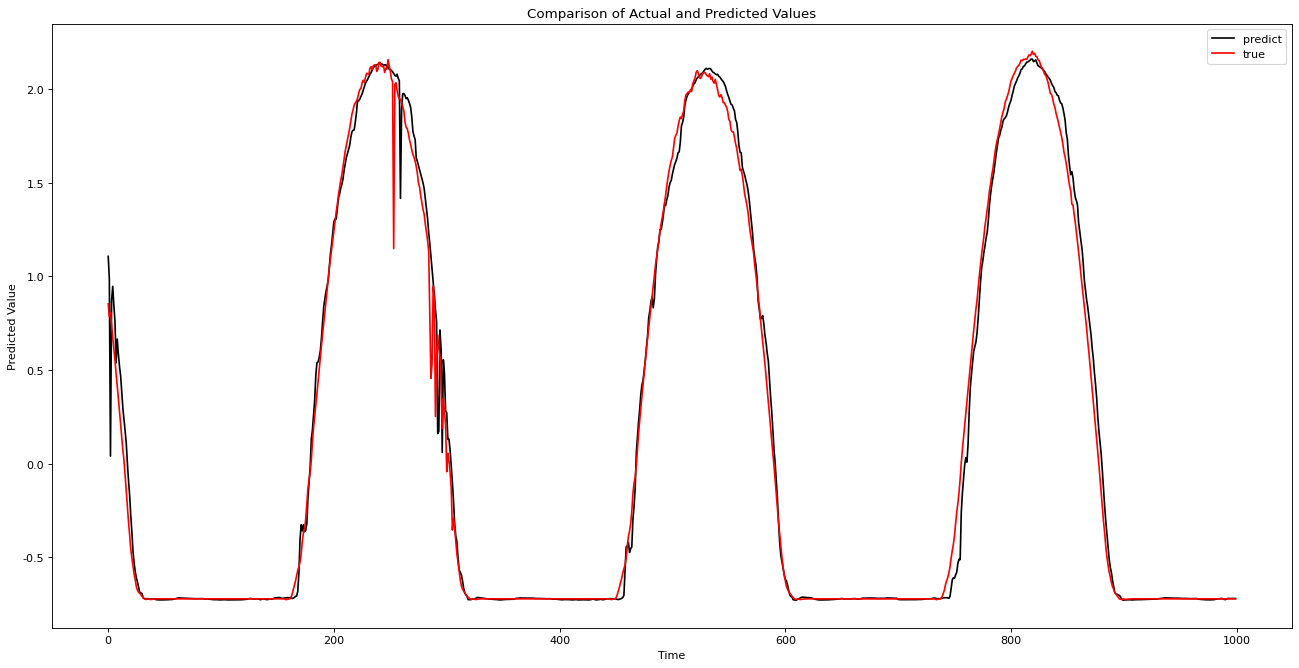

In [28]:
y_predict = y_pred.cpu().numpy()

num_test_samples = len(y_test_data)

x_predict = range(num_test_samples)

plt.figure(figsize=(20,10), dpi=80)
plt.plot(x_predict[:1000], y_predict[:1000], color='black', label='predict')
plt.plot(x_predict[:1000], y_test_data[:1000], color='red', label='true')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()


RNN model

Epoch [1/20], Train Loss: 0.0979, Test Loss: 0.1336
Epoch [2/20], Train Loss: 0.0686, Test Loss: 0.1407
Epoch [3/20], Train Loss: 0.0860, Test Loss: 0.1410
Epoch [4/20], Train Loss: 0.1205, Test Loss: 0.1382
Epoch [5/20], Train Loss: 0.1246, Test Loss: 0.1365
Epoch [6/20], Train Loss: 0.0694, Test Loss: 0.1378
Epoch [7/20], Train Loss: 0.1444, Test Loss: 0.1416
Epoch [8/20], Train Loss: 0.1150, Test Loss: 0.1410
Epoch [9/20], Train Loss: 0.2468, Test Loss: 0.1383
Epoch [10/20], Train Loss: 0.0741, Test Loss: 0.1371
Epoch [11/20], Train Loss: 0.1058, Test Loss: 0.1414
Epoch [12/20], Train Loss: 0.1439, Test Loss: 0.1380
Epoch [13/20], Train Loss: 0.1724, Test Loss: 0.1375
Epoch [14/20], Train Loss: 0.1548, Test Loss: 0.1429
Epoch [15/20], Train Loss: 0.1183, Test Loss: 0.1327
Epoch [16/20], Train Loss: 0.1068, Test Loss: 0.1410
Epoch [17/20], Train Loss: 0.0922, Test Loss: 0.1384
Epoch [18/20], Train Loss: 0.1093, Test Loss: 0.1418
Epoch [19/20], Train Loss: 0.1440, Test Loss: 0.1370
Ep

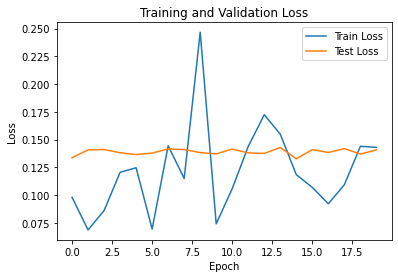

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_data, y_train_data, test_data, and y_test_data are properly defined
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(x_train_data, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(x_test_data, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Correctly handle tensor dimensions
        rnn_out, _ = self.rnn(x)
        # Apply dropout
        rnn_out = self.dropout(rnn_out)
        
        # Predict using fully connected layer
        output = self.fc(rnn_out)
        return output

# Get the number of features as input_size
input_size = 8
hidden_size = 32
output_size = 1

# Create model instance and move to GPU
model = RNNModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred.squeeze(), y_test_tensor)
    test_losses.append(test_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


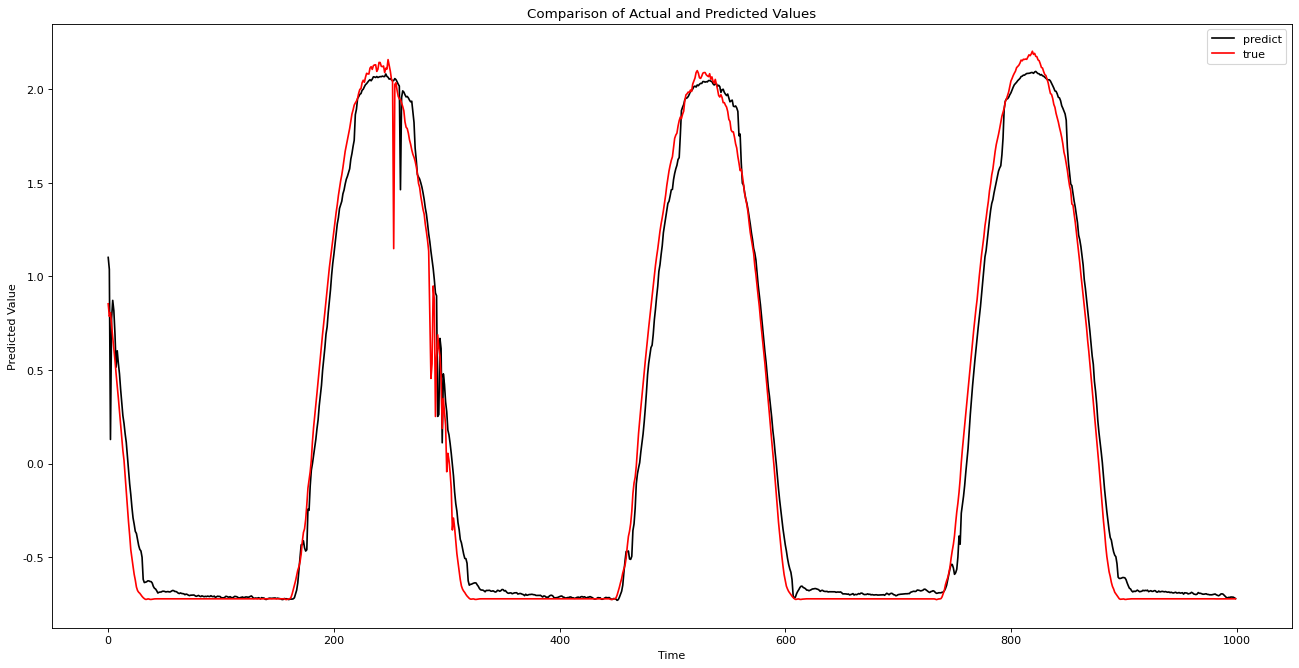

In [30]:
y_predict = y_pred.cpu().numpy()

num_test_samples = len(y_test_data)

x_predict = range(num_test_samples)

plt.figure(figsize=(20,10), dpi=80)
plt.plot(x_predict[:1000], y_predict[:1000], color='black', label='predict')
plt.plot(x_predict[:1000], y_test_data[:1000], color='red', label='true')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()
